In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

# Acquire train and test

In [2]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return dataset

def one_hot_encoder(dataset):
    encoded_df = pd.DataFrame(index=dataset.index)
    features = dataset.columns.tolist()
    for i,feature in enumerate(features):
        ohe = OneHotEncoder(sparse=False, categories='auto')
        encoded_matrix = ohe.fit_transform(dataset[[feature]])
        encoded_dfi = pd.DataFrame(encoded_matrix, columns=ohe.categories_[0], index=dataset[feature].index)
        encoded_df = pd.concat([encoded_df,encoded_dfi], axis =1)
    return encoded_df

def prep_data(df):
    df=df.reset_index(drop = True)
    data_dict = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')

    #Drop non_useful features
    identifier_features =data_dict[data_dict['Category']=='identifier']['Variable Name'].tolist() + ['icu_id']
    type__features=['hospital_admit_source','icu_admit_source', 'icu_stay_type']
    redundant_features = ['readmission_status', 'apache_2_bodysystem']
    features_to_drop = identifier_features + type__features +redundant_features
    df = df.drop(columns=features_to_drop)

    #Handling Missing values
    cut_off_percentage = .3
    n_of_nulls = int(cut_off_percentage * df.shape[0])
    # drop features that have more than 70% of nulls
    df = df.dropna(axis=1, thresh = n_of_nulls)

    #Imputation of numeric variables
    #get numeric feature names 
    numeric_features = data_dict[data_dict['Data Type']=='numeric']['Variable Name'].tolist()+ ['bmi','apache_2_diagnosis','apache_3j_diagnosis']
    skewed_numeric_features = df.columns[df.columns.isin(numeric_features)]
    numeric_df = df[skewed_numeric_features]
    # Use iterative Imputer to fill in null with the information of other features
    imp = IterativeImputer(max_iter=1, verbose=0)
    imp.fit(numeric_df)
    imputed_df = imp.transform(numeric_df)
    imputed_df = pd.DataFrame(imputed_df, columns=numeric_df.columns)

    #Imputation of categorical variables
    categorical_features = data_dict[data_dict['Data Type']!='numeric']['Variable Name'].tolist()
    categorical_features =[feature for feature in categorical_features if feature not in ['bmi','apache_2_diagnosis','apache_3j_diagnosis']]
    skewed_categorical_features = df.columns[df.columns.isin(categorical_features)]
    categorical_df = df[skewed_categorical_features]
    # fill the null with the most occurred values
    # df.series.mode() returns a series. so [0] exact value of the series
    for feature in skewed_categorical_features:
        categorical_df[feature].fillna(categorical_df[feature].mode()[0],inplace=True)

    # concat two data frame together horizontally
    complet_df = pd.concat([imputed_df, categorical_df], axis = 1)

    # Create a new feature which is the gcs score
    complet_df['GCS'] = complet_df['gcs_eyes_apache'] + complet_df['gcs_motor_apache'] + complet_df['gcs_verbal_apache']
    complet_df = complet_df.drop(columns= ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']) 
    
    # Reduce highly correlated numerical features
    reduced_dim_df = pd.concat([correlation(imputed_df.copy(), .9), categorical_df], axis = 1)
    reduced_dim_df
                                   
    # Label encoding gender
    complet_df['gender']= complet_df['gender'].apply(lambda x: 1 if x =='M' else 0)

    # One hot encoding ethnicity and appce 3j bodysystem
    dataset = complet_df[['ethnicity', 'apache_3j_bodysystem','icu_type']]
    encoded_df = one_hot_encoder(dataset)

    # Concat encoded dataframe to the complete df
    # Drop the selected features
    complet_df = pd.concat([complet_df, encoded_df], axis=1).drop(columns =['ethnicity', 'apache_3j_bodysystem','icu_type'])
    return complet_df


In [3]:
from sklearn.model_selection import train_test_split

df =  pd.read_csv('data/training_v2.csv')
train, test = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)
train = prep_data(train)
test = prep_data(test)


In [4]:
train

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,...,Sepsis,Trauma,CCU-CTICU,CSICU,CTICU,Cardiac ICU,MICU,Med-Surg ICU,Neuro ICU,SICU
0,72.0,32.041330,154.9,0.061111,76.880000,2.000000,113.0,501.02,2.400000,26.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,58.0,34.334291,190.5,0.032639,124.600000,2.500000,113.0,501.01,1.200000,70.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,78.0,32.764004,165.0,2.527083,89.200000,2.758715,218.0,1505.01,1.223745,17.975864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,65.0,32.992135,172.7,0.122917,98.400000,3.300000,112.0,107.01,0.600000,21.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,45.0,20.381570,173.0,0.054167,61.000000,3.400000,303.0,208.01,1.900000,14.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73365,82.0,27.960724,172.7,3.011111,83.968342,2.952488,301.0,1506.04,1.101295,10.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73366,64.0,32.553708,182.9,0.007639,108.900000,2.962029,302.0,111.01,1.132788,87.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
73367,56.0,28.000478,172.7,0.005556,84.093129,2.839697,105.0,207.01,1.201243,11.784314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
73368,27.0,27.476316,170.1,0.004167,79.500000,1.400000,307.0,701.01,0.200000,46.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Scale numerical features

In [5]:
data_dict = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')

In [6]:
numeric_features = (data_dict[data_dict['Data Type']=='numeric']['Variable Name'].tolist()
                    + ['bmi','apache_3j_diagnosis'])
numeric_features = train.columns[train.columns.isin(numeric_features)]


In [7]:
train[numeric_features]

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_3j_diagnosis,bilirubin_apache,bun_apache,creatinine_apache,...,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
0,72.0,32.041330,154.9,0.061111,76.880000,2.000000,501.02,2.400000,26.000000,1.640000,...,1.800000,1.800000,43.843746,38.272271,7.346301,7.299580,186.488882,86.858267,0.22,0.11
1,58.0,34.334291,190.5,0.032639,124.600000,2.500000,501.01,1.200000,70.000000,2.850000,...,1.400000,1.400000,53.365915,41.188882,7.426934,7.366781,68.204225,104.637853,0.62,0.53
2,78.0,32.764004,165.0,2.527083,89.200000,2.758715,1505.01,1.223745,17.975864,0.736784,...,1.593519,1.482389,44.802571,40.030095,7.386263,7.342399,141.613312,111.602132,0.04,0.01
3,65.0,32.992135,172.7,0.122917,98.400000,3.300000,107.01,0.600000,21.000000,1.100000,...,1.593519,1.482389,45.862075,40.281349,7.398869,7.343899,159.830552,111.098208,-1.00,-1.00
4,45.0,20.381570,173.0,0.054167,61.000000,3.400000,208.01,1.900000,14.000000,0.900000,...,1.593519,1.482389,29.200000,29.200000,7.412000,7.412000,173.000000,173.000000,0.03,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73365,82.0,27.960724,172.7,3.011111,83.968342,2.952488,1506.04,1.101295,10.000000,0.750000,...,1.200000,1.200000,37.300000,37.300000,7.430000,7.430000,90.600000,90.600000,0.11,0.01
73366,64.0,32.553708,182.9,0.007639,108.900000,2.962029,111.01,1.132788,87.000000,3.230000,...,0.900000,0.900000,51.239176,40.598885,7.449126,7.378341,150.956008,101.550892,0.12,0.03
73367,56.0,28.000478,172.7,0.005556,84.093129,2.839697,207.01,1.201243,11.784314,1.028845,...,1.200000,1.100000,48.742009,40.599518,7.424702,7.360857,137.704987,108.925043,0.01,0.01
73368,27.0,27.476316,170.1,0.004167,79.500000,1.400000,701.01,0.200000,46.000000,3.140000,...,1.593519,1.482389,40.154166,36.257745,7.368095,7.300414,168.469847,114.001212,0.05,0.03


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler =MinMaxScaler()\
            .fit(train[numeric_features])

In [9]:
train[numeric_features]=scaler.transform(train[numeric_features])

In [10]:
train[numeric_features]

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_3j_diagnosis,bilirubin_apache,bun_apache,creatinine_apache,...,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
0,0.563743,0.345308,0.303134,0.135887,0.259701,0.295164,0.227621,0.050846,0.337624,0.120934,...,0.131272,0.172183,0.274770,0.329131,0.516193,0.566566,0.595913,0.232533,0.613065,0.563452
1,0.422808,0.387272,0.912828,0.135732,0.583446,0.427661,0.227616,0.027410,0.626184,0.227153,...,0.072929,0.095657,0.377602,0.370203,0.658725,0.645891,0.461035,0.270224,0.814070,0.776650
2,0.624144,0.358534,0.476109,0.149286,0.343284,0.496219,0.683766,0.027873,0.285000,0.041646,...,0.101155,0.111419,0.285125,0.353885,0.586833,0.617111,0.544742,0.284987,0.522613,0.512690
3,0.493275,0.362709,0.607981,0.136222,0.405699,0.639657,0.048609,0.015692,0.304833,0.073531,...,0.101155,0.111419,0.296567,0.357423,0.609115,0.618881,0.565515,0.283919,0.000000,0.000000
4,0.291939,0.131924,0.613119,0.135849,0.151967,0.666157,0.094497,0.041081,0.258926,0.055974,...,0.101155,0.111419,0.116631,0.201374,0.632327,0.699268,0.580532,0.415143,0.517588,0.517766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73365,0.664412,0.270629,0.607981,0.151916,0.307791,0.547568,0.684234,0.025482,0.232693,0.042806,...,0.043757,0.057394,0.204104,0.315440,0.664145,0.720515,0.486573,0.240465,0.557789,0.512690
73366,0.483209,0.354685,0.782668,0.135596,0.476934,0.550097,0.050426,0.026097,0.737673,0.260511,...,0.000000,0.000000,0.354635,0.361895,0.697953,0.659536,0.555395,0.263680,0.562814,0.522843
73367,0.402674,0.271357,0.607981,0.135585,0.308637,0.517679,0.094042,0.027434,0.244395,0.067284,...,0.043757,0.038263,0.327667,0.361904,0.654780,0.638898,0.540286,0.279312,0.507538,0.512690
73368,0.110735,0.261764,0.563453,0.135577,0.277476,0.136167,0.318483,0.007880,0.468788,0.252610,...,0.101155,0.111419,0.234926,0.300762,0.554717,0.567551,0.575366,0.290073,0.527638,0.522843


# Clustering

## DBSCAN

In [11]:
# from sklearn.cluster import DBSCAN

# dbsc = DBSCAN(eps = .1, min_samples = 20).fit(train[numeric_features])

# labels = dbsc.labels_
# np.unique(labels)

Took forever to run, have to give up.

## Kmeans

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

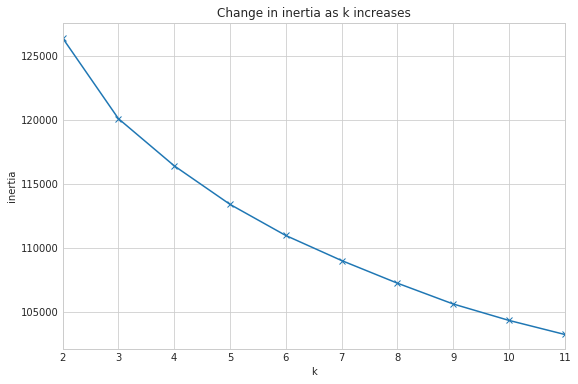

In [13]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(train[numeric_features]).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [25]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(train[numeric_features])
train['cluster'] = kmeans.predict(train[numeric_features])
test['cluster'] = kmeans.predict(test[numeric_features])

In [26]:
train.cluster.value_counts()

0    23267
3    18880
2    15744
1    15479
Name: cluster, dtype: int64

## Modeling

### Logistic regression

In [27]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression

In [28]:
y_train = train['hospital_death']
X_train = train.drop(columns='hospital_death')
y_test = test['hospital_death']
X_test = test.drop(columns='hospital_death')

In [29]:
lr = LogisticRegression(C=1)
lr.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
from sklearn.metrics import roc_auc_score

In [31]:
lr_probs_tra = lr.predict_proba(X_train)
lr_probs_tes = lr.predict_proba(X_test)
lr_probs_tra = lr_probs_tra[:, 1]
lr_probs_tes = lr_probs_tes[:, 1]
score_tra= roc_auc_score(y_train, lr_probs_tra)
score_tes= roc_auc_score(y_test, lr_probs_tes)
score = (score_tra, score_tes)

In [32]:
score

(0.8789541692130487, 0.5244582391670448)

### Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
dt = DecisionTreeClassifier(max_depth=10,criterion='gini')
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [35]:
dt_probs_tra = dt.predict_proba(X_train)
dt_probs_tes = dt.predict_proba(X_test)
dt_probs_tra = dt_probs_tra[:, 1]
dt_probs_tes = dt_probs_tes[:, 1]
score_tra= roc_auc_score(y_train, dt_probs_tra)
score_tes= roc_auc_score(y_test, dt_probs_tes)
score = (score_tra, score_tes)

In [36]:
score

(0.8948740877337237, 0.5834659765075526)

So clustering is not very use for predicting test result.

In [38]:
df =  pd.read_csv('data/training_v2.csv')

[Text(0, 0, 'live'), Text(0, 0, 'dead')]

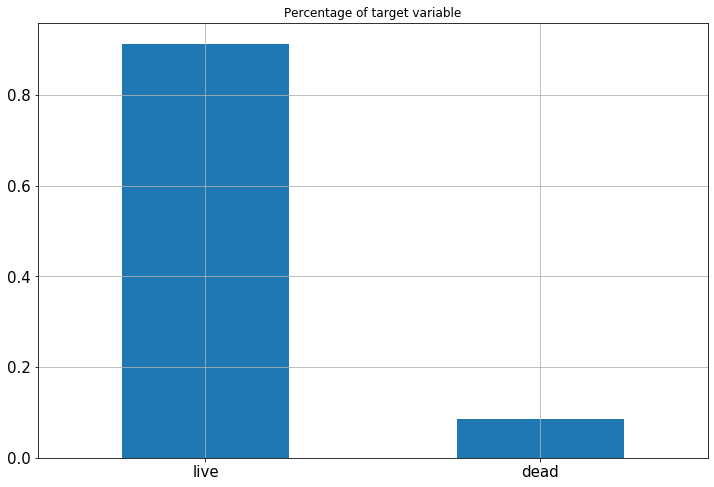

In [54]:
ax = df['hospital_death'].value_counts(normalize=True)\
    .plot.bar(figsize=(12,8),
              grid=True,
             title='Percentage of target variable',
             fontsize = 15)
ax.set_xticklabels(labels=['live','dead'], rotation=0)
